<a href="https://colab.research.google.com/github/mrromaniuc/quantum-computing/blob/main/QC_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-visualization
!pip install qiskit-ibm-provider
!pip install qiskit-ibm-runtime
!pip install qiskit-experiments
!pip install qiskit-circuit
!pip install imgaug==0.2.5
!pip install pylatexenc

In [2]:
#Setting configuration to use matplotlib in drawings
!mkdir ~/.qiskit
!echo "[default]" > ~/.qiskit/settings.conf
!echo "circuit_drawer = mpl" >> ~/.qiskit/settings.conf
!more ~/.qiskit/settings.conf


#
# Loading IBM credentials
#
API_TOKEN_DIR="/content/drive/'My Drive'/'Colab Notebooks'/QC"
API_TOKEN_FILE="MY_API_TOKEN.txt"

#Mount the google drive first
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/'My Drive'/'Colab Notebooks'/QC
%cd $API_TOKEN_DIR

#Read the MY_API_TOKEN from file...
from qiskit_ibm_provider import IBMProvider
MY_API_TOKEN = ""
with open(API_TOKEN_FILE) as f:
  MY_API_TOKEN=f.readline()
IBMProvider.save_account(MY_API_TOKEN, overwrite=True)

[default]
circuit_drawer = mpl
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/QC


References:
* https://learning.quantum-computing.ibm.com/course/variational-algorithm-design/examples-and-applications


## Max-Cut

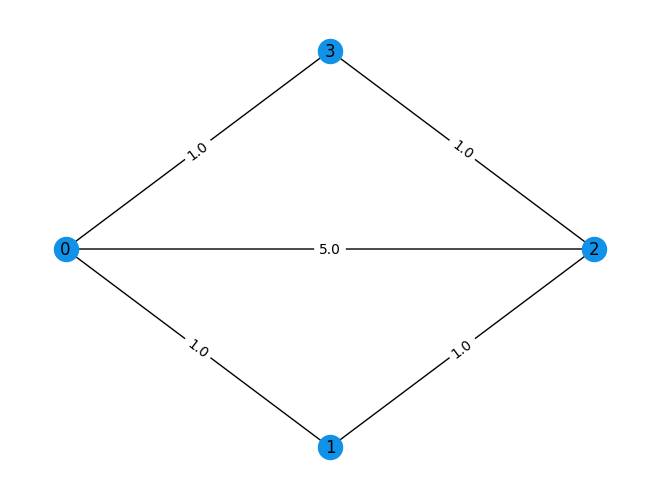

In [16]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
edges = [ (0,1,1.0), (0, 2, 5.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0) ]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color='#1192E8')

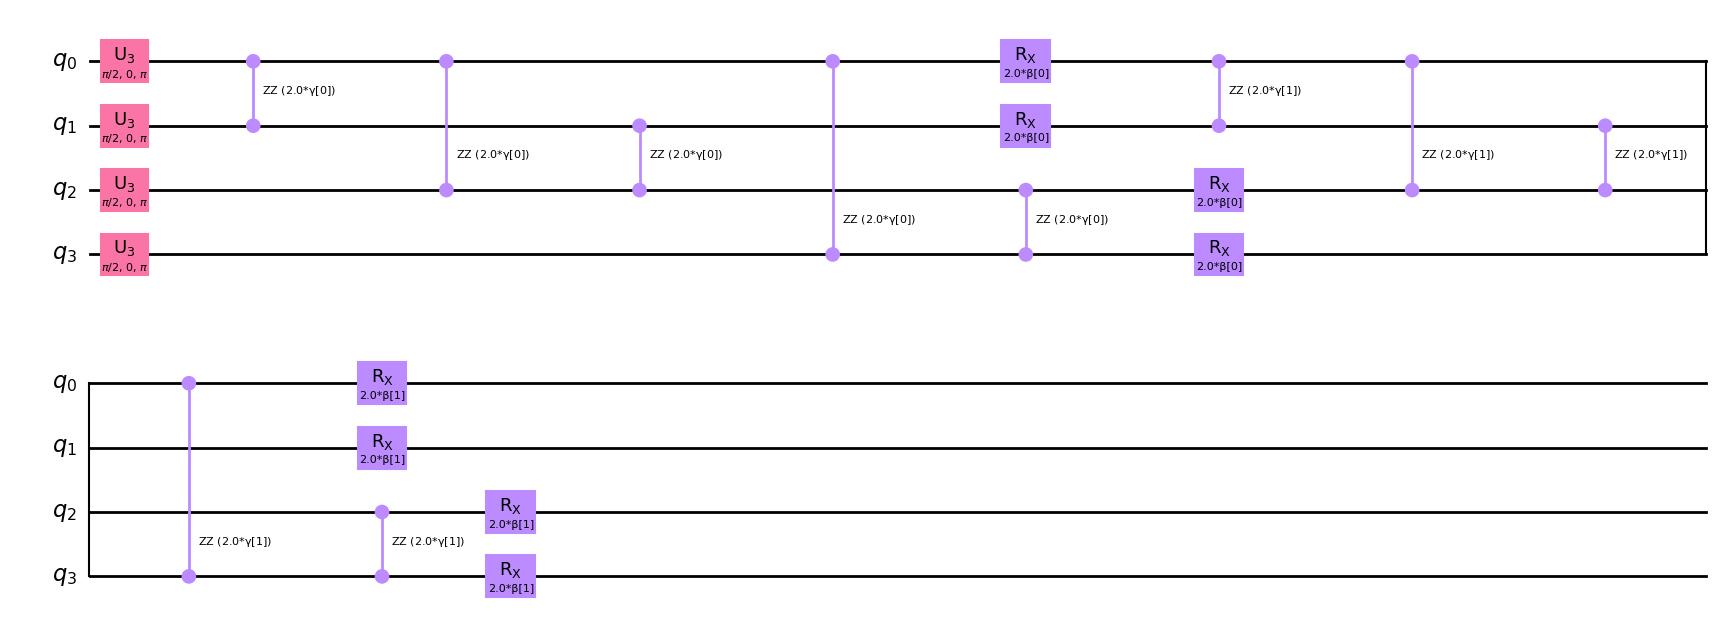

In [17]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list( [
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw("mpl")

In [18]:
offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -4.5


In [19]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [20]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

In [21]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

In [ ]:
result = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

In [11]:
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.7045
       x: [ 2.339e+00  1.271e+00  4.333e+00  6.883e-01]
    nfev: 53
   maxcv: 0.0


In [12]:
eigenvalue = cost_func(result.x, ansatz, hamiltonian, estimator)
print(f"""Eigenvalue: {eigenvalue}""")
print(f"""Max-Cut Objective: {eigenvalue + offset}""")

Eigenvalue: -1.7149999999999999
Max-Cut Objective: -4.215


In [13]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(result.x)

# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]

# Close the session since we are now done with it
session.close()

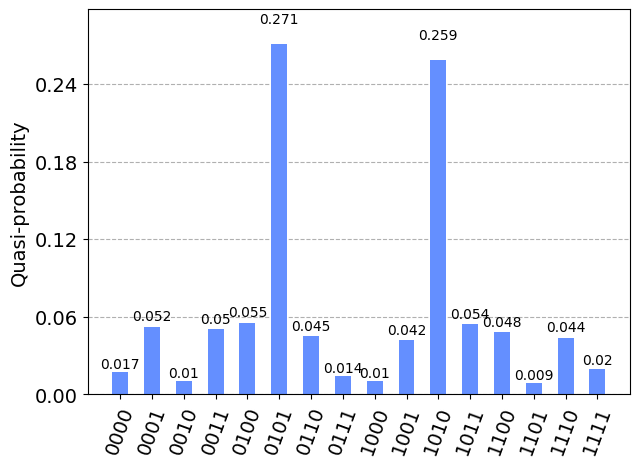

In [14]:
from qiskit.visualization import plot_distribution

probabilities = samp_dist.binary_probabilities()
plot_distribution(probabilities)

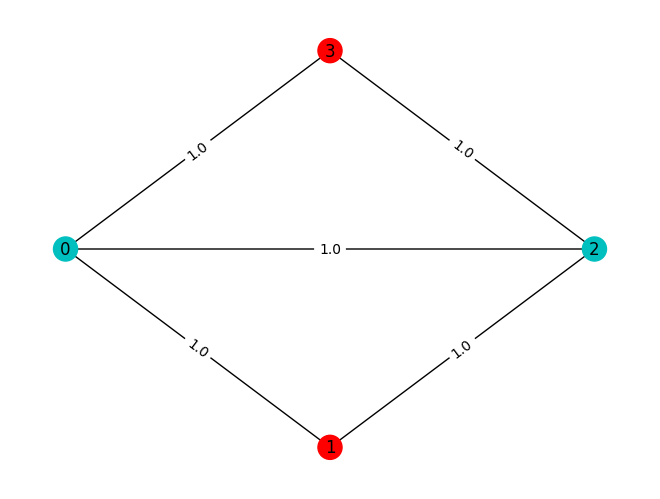

In [15]:
binary_string = max(probabilities.items(), key=lambda kv: kv[1])[0]
x = np.asarray([int(y) for y in reversed(list(binary_string))])

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color=colors)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table